# Import

In [1]:
from mne.io.snirf import read_raw_snirf
from get_events_from_snirf import get_events_from_snirf
from matplotlib import pyplot as plt
import numpy as np

In [2]:
from give_channels import give_channels

# Load File

In [3]:
path = '../data_hojjat/finger_tap/test_001_S001_b285d1f_5.snirf'

In [4]:
snirf = read_raw_snirf(path)
snirf

Loading /home/kernel/Desktop/py_test/project/data_hojjat/finger_tap/test_001_S001_b285d1f_5.snirf


/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/utils/check.py:91: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/utils/check.py:91: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LooseVersion(library.__version__) < LooseVersion(min_version):
/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/mne/externals/pymatreader/pymatreader.py:34: DeprecationWarning: Please use `get_matfile_version` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.miobase` namespace is deprecated.
  from scipy.io.matlab.miobase import get_matfile_version


<RawSNIRF | test_001_S001_b285d1f_5.snirf, 4168 x 5565 (779.5 s), ~5.6 MB, data not loaded>

# Events

In [5]:
events = get_events_from_snirf(path, False)

In [6]:
events

,Timestamp,Event,Duration,Value,Block,Trial,ExperimentType,TrialType,BlockType
0,17.676924,StartExperiment,757.450710,1.0,NaN,NaN,Urn:Kernel.Com/Task/FlowNeuroFt/02,NaN,NaN
1,17.705501,StartRest,20.017202,1.0,NaN,NaN,Urn:Kernel.Com/Task/FlowNeuroFt/02,NaN,NaN
2,37.737653,StartBlock,16.980013,1.0,1.0,NaN,Urn:Kernel.Com/Task/FlowNeuroFt/02,NaN,Left
3,37.737867,StartIti,0.884177,1.0,1.0,NaN,Urn:Kernel.Com/Task/FlowNeuroFt/02,NaN,Left
4,38.622133,StartTrial,0.783437,1.0,1.0,1.0,Urn:Kernel.Com/Task/FlowNeuroFt/02,Index,Left
...,...,...,...,...,...,...,...,...,...
558,752.585214,StartTrial,0.791566,1.0,20.0,259.0,Urn:Kernel.Com/Task/FlowNeuroFt/02,Pinky,Right
559,753.376884,StartIti,0.938310,1.0,20.0,NaN,Urn:Kernel.Com/Task/FlowNeuroFt/02,NaN,Right
560,754.315285,StartTrial,0.779285,1.0,20.0,260.0,Urn:Kernel.Com/Task/FlowNeuroFt/02,Index,Right
561,755.109588,StartRest,20.018035,1.0,NaN,NaN,Urn:Kernel.Com/Task/FlowNeuroFt/02,NaN,NaN


# Data

In [7]:
data = snirf.get_data()

In [8]:
data.shape

(4168, 5565)

# Channels


In [9]:
def select_channels(snirf, good_channels, hbo = 'HbO'):
    channel_names = [x['ch_name'] for x in snirf.info['chs']]
    out = []
    for i, name in enumerate(channel_names):
        if name[:9] in good_channels and hbo in name:
            out.append(i)
    out = np.array(out)
    return out

In [10]:
motor_nodes_right = give_channels()
motor_channels_right = select_channels(snirf, motor_nodes_right)

In [11]:
motor_channels_right.shape

(324,)

In [12]:
# data = data[motor_channels_right]

# Plot

In [13]:
def get_duration(events):
    duration = events[events['Duration'].round() >0].Duration.min().round().astype(int)
    return duration

In [14]:
def get_start_indexes(events, sampling_rate):
    start_indexes = (events.Timestamp.values*sampling_rate).round().astype(int)
    return start_indexes

In [15]:
def get_events_start_block(events, label):
    if label == 'Rest':
        events = events[events.Event == 'StartRest']
    else:
        events = events[(events.BlockType == label) & (events.Event == 'StartBlock')]
    return events

In [16]:
def get_data(all_data, start_indexes, duration):
    data = np.array([all_data[:, start_index:start_index + duration] for start_index in start_indexes])
    return data

In [17]:
def get_data_avg(data):
    data_avg = np.mean(data, axis=0)
    return data_avg

In [18]:
def _plot(snirf, data, duration):
    times = range(duration)
    channel_names = [x['ch_name'] for x in snirf.info['chs']]
    is_hbo = np.array([1 if channel_name.endswith(
       'HbO') else 0 for channel_name in channel_names], dtype=bool)
    channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']]

    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].pcolor(times, np.arange(np.sum(is_hbo)),
                data[is_hbo, :], shading='nearest')
    ax[0].set_title('HbO')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Channel number')
    ax[1].pcolor(times, np.arange(np.sum(~is_hbo)),
                data[~is_hbo, :], shading='nearest')
    ax[1].set_title('HbR')
    ax[1].set_xlabel('Time [s]')
    # plt.show() 

In [19]:
def plot(snirf, all_data, all_events, sampling_rate, label):
    events = get_events_start_block(all_events, label)
    duration = get_duration(events)
    start_indexes = get_start_indexes(events, sampling_rate)
    data = get_data(all_data, start_indexes, duration)
    data_avg = get_data_avg(data)
    _plot(snirf, data_avg, duration)
    return data, data_avg

In [20]:
sampling_rate = 7.14 #8.26 #7.14

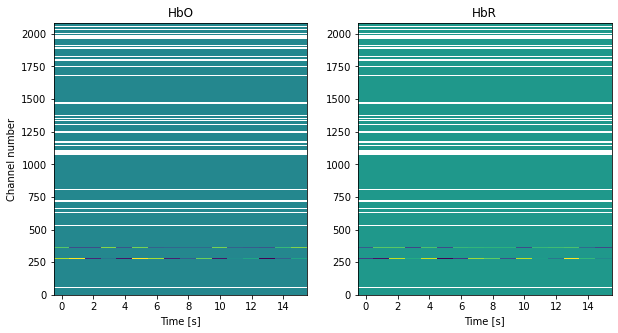

In [21]:
data_right, data_avg_right = plot(snirf, data, events, sampling_rate, 'Right')

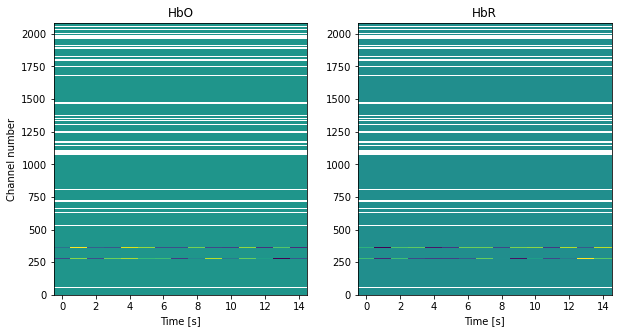

In [22]:
data_left, data_avg_left = plot(snirf, data, events, sampling_rate, 'Left')

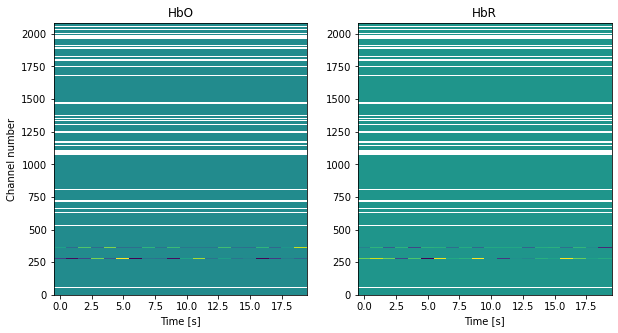

In [23]:
data_rest, data_avg_rest = plot(snirf, data, events, sampling_rate, 'Rest')

In [24]:
def drop_nan(data):
    clean = data[np.sum(np.isnan(data), axis=1) == 0]
    return clean

In [25]:
tmp = np.mean(drop_nan(data_avg_rest), axis = 0)

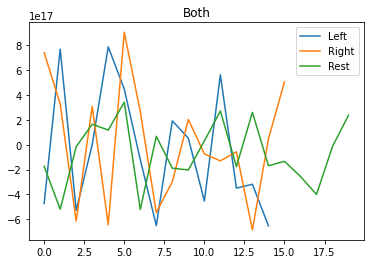

In [26]:
plt.plot((np.mean(drop_nan(data_avg_left), axis=0) ), label='Left')
plt.plot((np.mean(drop_nan(data_avg_right), axis= 0)), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest), axis = 0) , label='Rest')
plt.legend()
plt.title('Both')
plt.show()

In [27]:
channel_names = [x['ch_name'] for x in snirf.info['chs']]
is_hbo = np.array([1 if channel_name.endswith(
       'HbO') else 0 for channel_name in channel_names], dtype=bool)

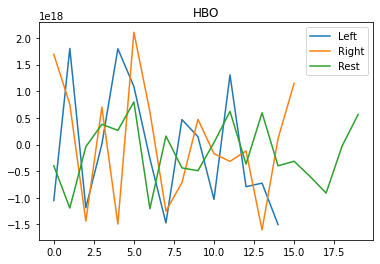

In [28]:
plt.plot(np.mean(drop_nan(data_avg_left[is_hbo]), axis=0), label='Left')
plt.plot(np.mean(drop_nan(data_avg_right[is_hbo]), axis= 0), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest[is_hbo]), axis = 0), label='Rest')
plt.legend()
plt.title('HBO')
plt.show()

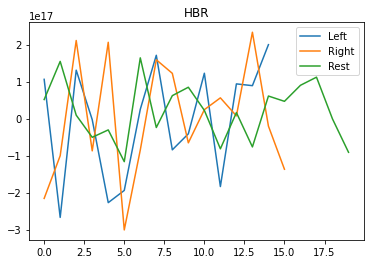

In [29]:
plt.plot(np.mean(drop_nan(data_avg_left[~is_hbo]), axis=0), label='Left')
plt.plot(np.mean(drop_nan(data_avg_right[~is_hbo]), axis= 0), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest[~is_hbo]), axis = 0), label='Rest')
plt.legend()
plt.title('HBR')
plt.show()

In [ ]:
np.mean(data_avg_left, axis=0)

In [ ]:
duration_right = get_duration(events_right)
start_index_right = get_start_indexes(events_right, 8.26)

In [ ]:
data_right = np.array([data[:, start_index:start_index + duration_right] for start_index in start_index_right])

In [ ]:
data_right_avg = np.mean(data_right, axis=0)

In [ ]:
plot(snirf, data_right_avg, duration_right)